# MST Vincolato
Dato un grafo non orientato e non completo, e dato un nodo r, si determini l’albero di copertura di radice r che minimizza il numero di figli di ogni nodo -1 (dato un albero di copertura, orientato a partire dalla radice, ogni nodo i non foglia ha ki ≥ 1 figli. Si minimizza la somma su tutti i nodi i non foglia di ki-1)

In [546]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from random import seed, randint
import time

In [547]:
# PARAMETRI GENERALI
OUT_DIR = "out/greedy_depth_first" # dove salvare i disegni dei grafi (x debug)

ROOT_NODE = 5
MAX_NODES = 226
GRAPH_GENERATOR = "SPARSE" # [NX_ATLAS | NX_COMPLETE | NX_DENSE | NX_RANDOM | DENSE | SPARSE | NOT_BEST_PATH ]
RANDOM_SEED = 191295

### Inizializzazione

In [548]:
# CREAZIONE GRAFO e strutture

# TODO importa grafo da file


# Grafo di test
if not "GRAPH_GENERATOR" in globals():
    GRAPH_GENERATOR = "CUSTOM"
else :
    match GRAPH_GENERATOR:
        case "NX_ATLAS": 
            # generatore "atlas" di networkx
            # non sono grafi molto densi, e sono piccoli
            # 666
            # 420
            # 969
            # 1196
            atlas_num = 969
            print("[INFO] Uso generatore nx.atlas (seed={})".format(atlas_num))
            G = nx.graph_atlas(atlas_num)

        case "NX_COMPLETE":
            print("[INFO] Uso generatore grafo completo (n={})".format(MAX_NODES))
            G = nx.complete_graph(range(1,MAX_NODES+1))

        case "NX_DENSE":
            n = MAX_NODES
            m = 2*int(n*(n-2)/3)
            print("[INFO] Uso generatore grafo denso (n={}, m={})".format(n,m))
            if "RANDOM_SEED" in globals():
                seed = RANDOM_SEED
            else:
                print("[WARN] Random seed non impostato. Verrà scelto a caso")
                seed = None
                
            G = nx.dense_gnm_random_graph(n, m, seed=seed)

        case "NX_RANDOM":
            G = nx.random_regular_graph(d=MAX_NODES%10, n=MAX_NODES)

        
        case "DENSE":
            print("[INFO] Uso generatore mio DENSE")
            G = nx.Graph()
            G.add_nodes_from([
                x for x in range(1, MAX_NODES+1)
            ])

            G.add_edges_from([
                (x,y) for x in range(1, MAX_NODES+1)
                    for y in range(x+1, MAX_NODES+1)
            ])

            # Rendiamo il grafo non completo
            G.remove_edges_from([ (1,4), (3,6), (5,3), (4,5)])
            G.remove_edges_from([ 
                (a,b) for a in range(MAX_NODES, int(MAX_NODES/2))
                      for b in [x for x in range(1,MAX_NODES-1) if (b+a) %3 != 0]
            ])

        case "SPARSE":
            n = MAX_NODES
            m = 3#3*int(n*(n/2)/10)
            print("[INFO] Uso generatore SPARSE (Barabasi-Albert, n={}, m={})".format(n,m))
            if "RANDOM_SEED" in globals():
                seed = RANDOM_SEED
            else:
                print("[WARN] Random seed non impostato. Verrà scelto a caso")
                seed = None
                
            G = nx.barabasi_albert_graph(n=n, m=m, seed=seed)

        case "NOT_BEST_PATH":
            G = nx.barabasi_albert_graph(n=int(MAX_NODES/2), m=6, seed=RANDOM_SEED)

            # Rendi impossibile trovare un percorso di lunghezza 0
            # aggiungendo nodi raggiungibili solo da uno stesso nodo
            n = len(G.nodes)
            #G.add_edges_from([(ROOT_NODE,x) for x in range(n, n + 5)]) # dummy

            # v.2 by prof. Nonato
            # come sopra ma pensato meglio
            n_0 = n
            star_count = 0
            seed(RANDOM_SEED)
            while n < MAX_NODES:
                n_star = min(MAX_NODES-n,5)
                star = nx.generators.star_graph(range(n,n+n_star))
                link_node = randint(0,n_0)
                G.add_edges_from(star.edges)
                G.add_edge(link_node, n)

                n += n_star
                star_count += 1

            print("[INFO] Aggiunte ",star_count, " stelle al grafo di partenza.")

            
        case _:
            # robetta semplice
            atlas_num = 1234
            print("[WARN] Generatore non valido, uso grafo di test (nx.atlas, id=1234)")
            G = nx.graph_atlas(atlas_num)

# Prepara directory in cui salvare i rendering
OUT_DIR = os.path.join(os.getcwd(),OUT_DIR)
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

[INFO] Uso generatore grafo denso (n=226, m=33748)


In [549]:
# Alcune funzioni di supporto

def draw_graph(graph, MST=nx.empty_graph(), root_node=None):
    # adapted from:
    # https://stackoverflow.com/questions/60164893/highlighting-certain-nodes-edges-in-networkx-issues-with-using-zip

    nodes_shared_options = {"node_size": 500, "edgecolors": "black", "linewidths": 1.2}
    edges_shared_options = {"connectionstyle": 'arc3', "width": 1.25} 
    
    # Get position using spring layout
    pos = nx.spring_layout(graph, seed=54321)
    #pos = nx.circular_layout(graph)

    # Get MST path
    path_edges = list(MST.edges)

    # Prepare the figure size
    plt.figure(figsize=(max(8,MAX_NODES/6),max(8,MAX_NODES/6)))

    # Draw nodes and edges not included in the MST path
    #nx.draw_networkx_nodes(graph, pos, nodelist=set(graph.nodes)-set(MST.nodes))
    nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes, node_color="whitesmoke", **nodes_shared_options)
    nx.draw_networkx_edges(graph, pos, edgelist=set(graph.edges)-set(path_edges), edge_color='gray', **edges_shared_options )

    # Draw MST path
    # highlight the root node
    if root_node != None:
        nx.draw_networkx_nodes(graph, pos, nodelist=[root_node], node_color='tab:red', **nodes_shared_options)

    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', **edges_shared_options)

    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_color='black', font_weight='bold')
    nx.draw_networkx_labels(graph, pos, labels={root_node: root_node}, font_color='whitesmoke', font_weight='bold')



def save_figure(name, format="svg"):
    filename = "{}.{}".format(name,format)
    plt.tight_layout(pad=1)
    plt.savefig(os.path.join(OUT_DIR,filename), bbox_inches='tight', format=format, dpi=800, transparent=True)



In [550]:
# Funzione obiettivo

def cost(MST, root_node=ROOT_NODE, debug=False):

    if debug:
        print("root node: ",root_node)

    support_graph = nx.Graph()

    visited = set()
    next = [root_node]
    
    cost = 0

    while len(next) > 0:
        node = next.pop(0)
        node_edges = MST.edges(node)
        
        if node not in visited:
            k_children = len( [ x for x in node_edges if x not in support_graph.edges ] )

            if debug:
                print("node {} has {} children".format(node, k_children))

            if k_children > 1:
                cost += k_children - 1

            visited.add(node)
            next = next + list(MST.adj[node])
            support_graph.add_edges_from(node_edges)
        
    return cost


## Greedy
Cerca di risolvere il problema con la visita in profondità e una lista di nodi visitati

In [551]:
# PARAMETRI RICERCA

# [Debug]
DEBUG_IMPROVEMENT = False
SAVE_STEP_GRAPHS = False    

In [552]:
# Creazione di MST con radice specificata tramite visita in profondità
MST = nx.Graph()

def recursive_depth_first(graph, node):
    children = graph.adj[node]
    for child in children:
        if child not in MST.nodes:
            MST.add_edge(node, child)
            recursive_depth_first(graph, child)

    return MST

In [553]:
# Creazione soluzione
mst = recursive_depth_first(G, ROOT_NODE)
#mst = nx.algorithms.minimum_spanning_tree(G, algorithm="kruskal")
#print("Graph nodes:",list(G.nodes))
#print("MST Nodes:",list(mst.nodes))
#print("Missing:",[n for n in G.nodes if n not in mst.nodes])
#draw_graph(mst,mst)

### 3. Risultati


In [554]:
# PRINT RESULTS
print("Costo: ", cost(mst, ROOT_NODE))
print("MST = ",mst.edges)

print("")
print("---DETTAGLI---")
print("Nodi non ottimali (nodo: n. figli): ",[{n: x-(ROOT_NODE!=n)*1} for (n,x) in mst.degree() if x > 2])
V = G.number_of_nodes()
E = G.number_of_edges()
print("Generatore: ",GRAPH_GENERATOR)
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("grafo è non completo: ", not (E == V*(V-1)/2))

print("soluzione è un albero: ",nx.is_tree(mst))

try:
    cycletest = nx.algorithms.cycles.find_cycle(mst, orientation="ignore")
except:
    cycletest = None
finally:
    print("cicli in soluzione: ", cycletest)


Costo:  0
MST =  [(5, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 88), (88, 89), (89, 90), (90, 91), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99), (99, 100), 

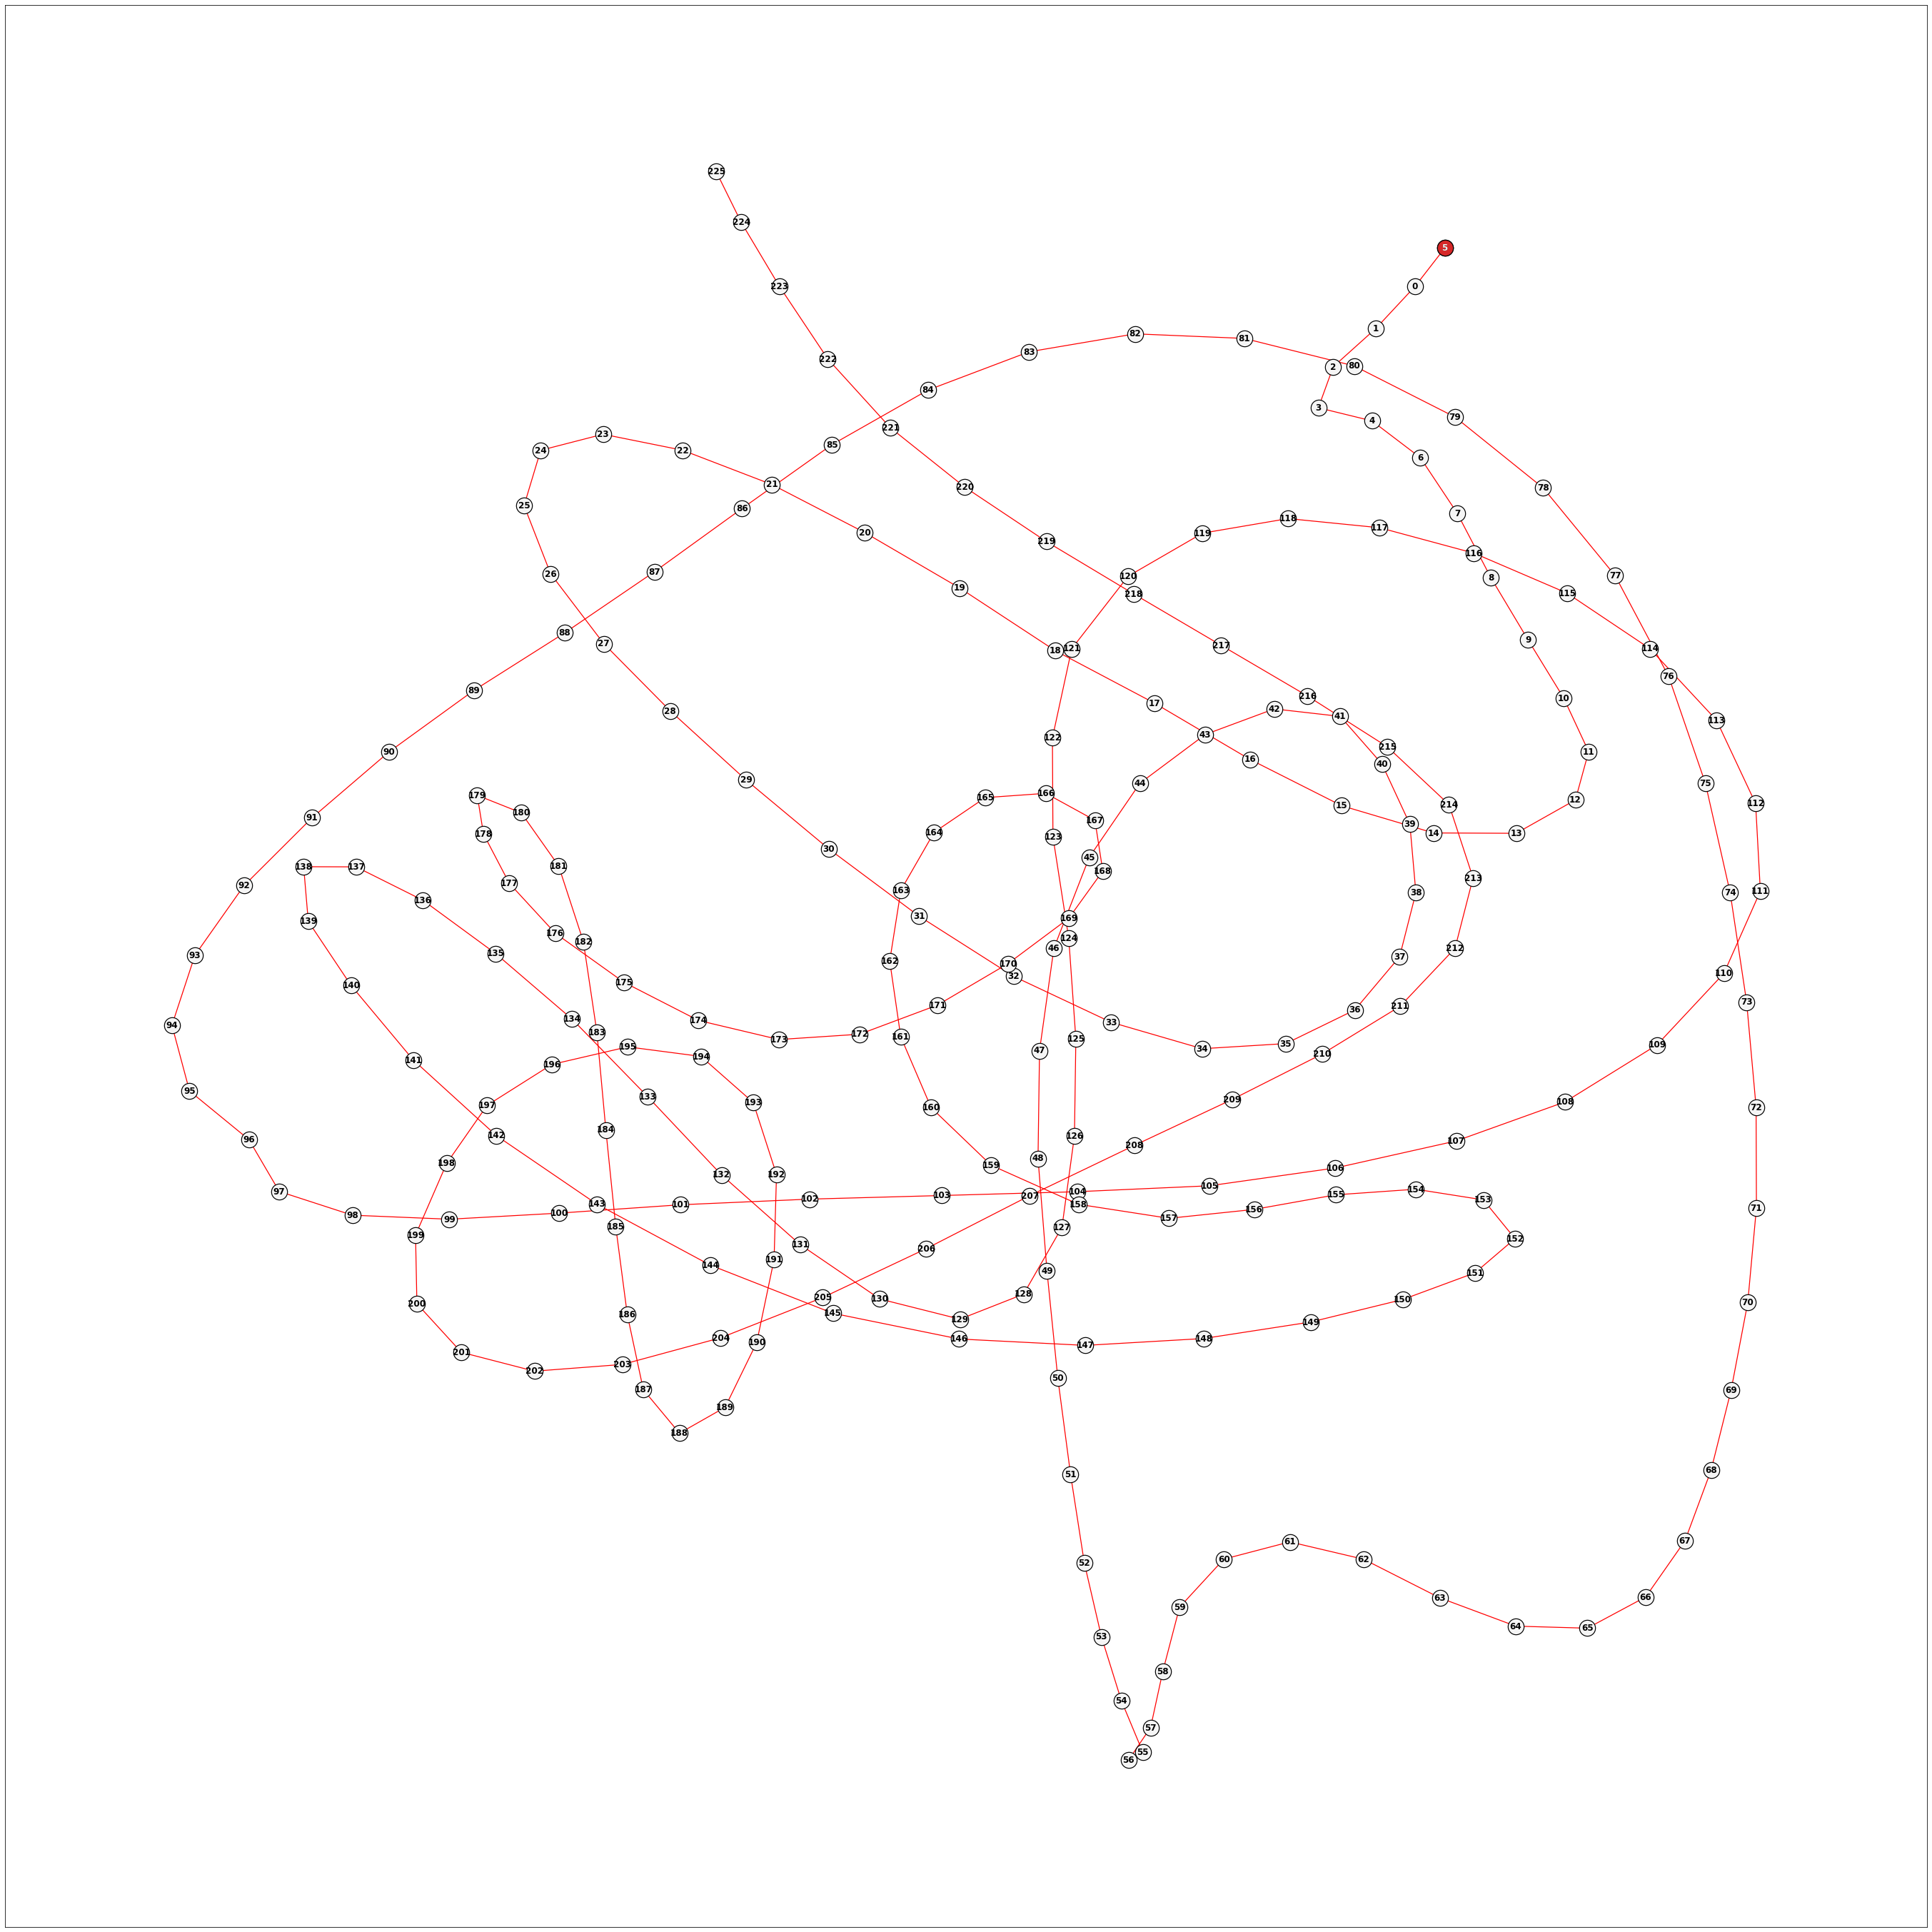

In [555]:
# RENDERING MST
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_final")

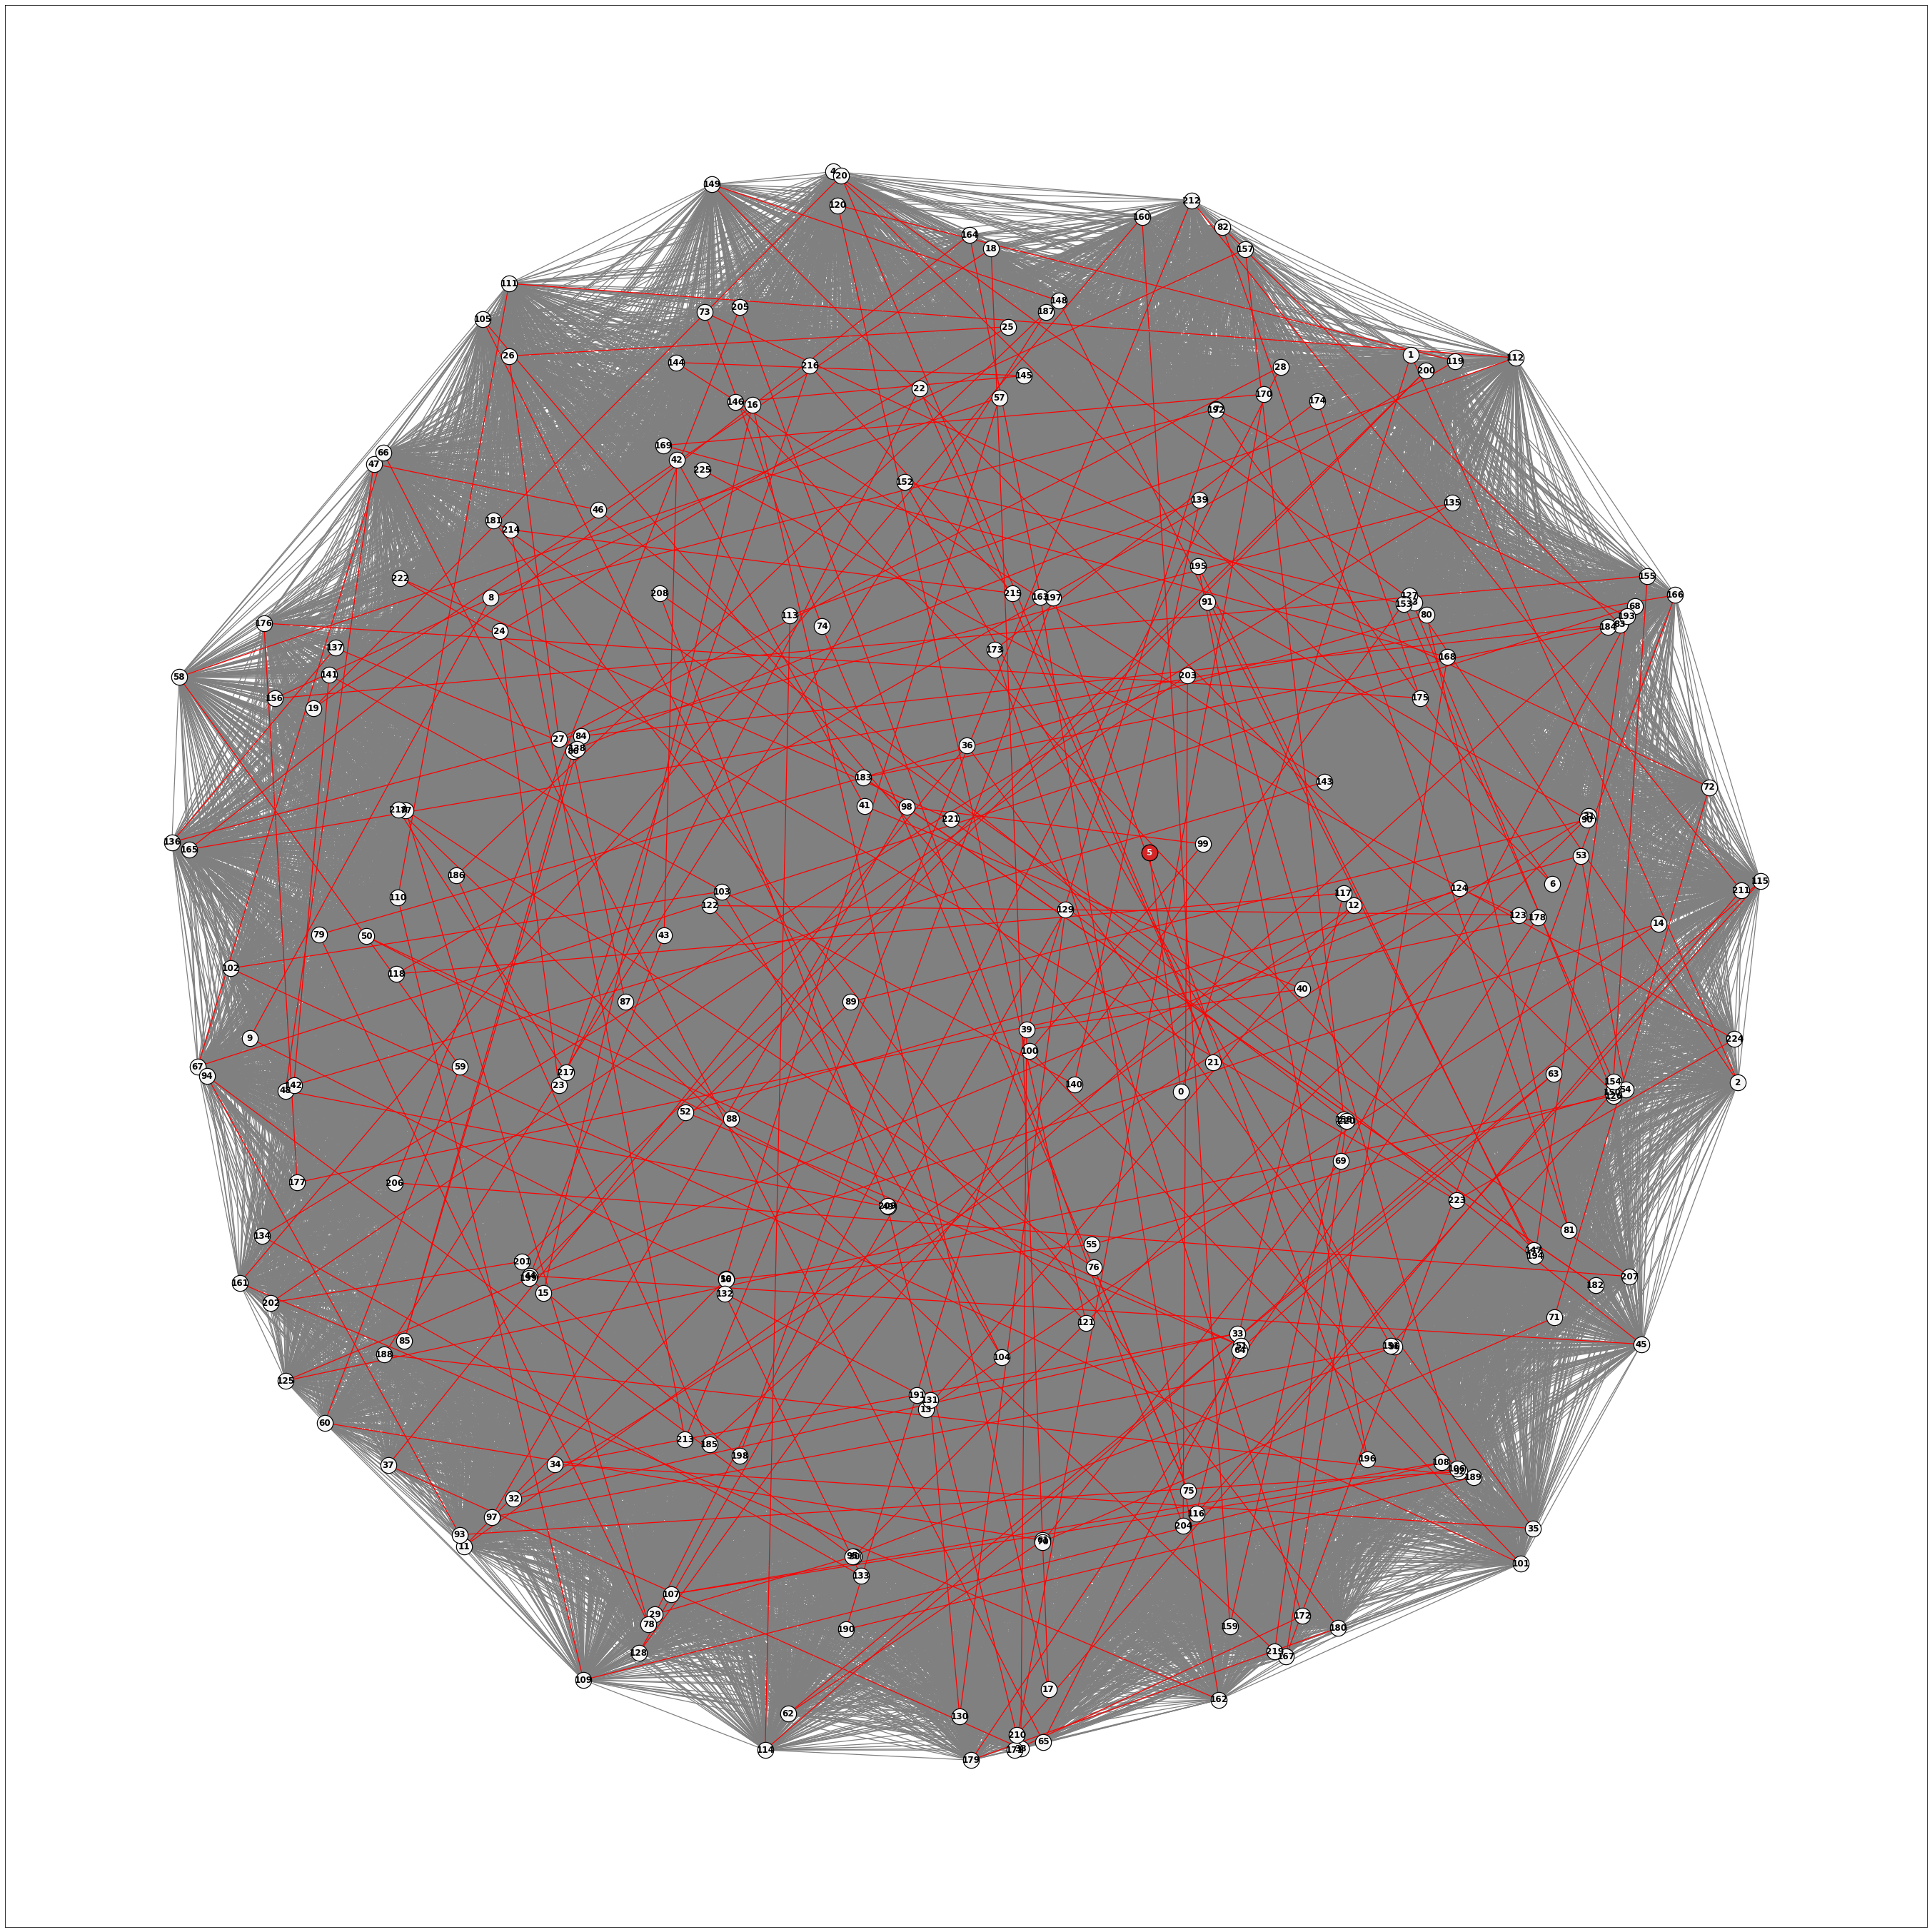

In [556]:
# RENDERING MST SOPRA AL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="final")